In [95]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.utils.visualize_util import plot
from keras.models import model_from_json



%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import time

In [2]:
#Load origional MNIST Data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
#seperate zeros from the rest of the data
zeros_seperate_images = []
for i in range(len(y_train)):
    if y_train[i] == 0:
        zeros_seperate_images.append(X_train[i])
        

In [36]:
#Add noise to the images

noiseRange = 50 #Must be a number between 0 and 255

def addNoiseToImage(X, noiseRange):
    for i in range(len(X)):
        for j in range(len(X[0])):
            if X[i][j] == 0:
                X[i][j] = np.random.random()*noiseRange
            

In [39]:
addNoiseToImage(zeros_seperate_images[1], noiseRange)

('Number of Zeros: ', 5923)


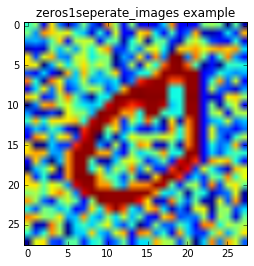

In [45]:
print('Number of Zeros: ', len(zeros_seperate_images))

plt.imshow(zeros_seperate_images[1])
plt.title('zeros1seperate_images example')
plt.show()

In [83]:
#Concatonation Function

# A function that takes in a 
# np.array(size:numberofImages x 28 x 28)
# mnist pictures in the first parameter and 
# the desired ouput size of one side of 
# the square final picture in the second parameter 
# and creates an imagewith the number placed 
# randomly in the image without overlapping

#the top left number in the image is the number of
#objects in the image, just did this for convenience

def insertImage(A, B, topLeftCoordinate):
    xi = topLeftCoordinate[0]
    yi = topLeftCoordinate[1]
    for i in range(28):
        for j in range(28):
            A[xi+i][yi+j] = B[i][j]

def updatePlacementMatrix(A, topLeftCoordinate):
    xi = topLeftCoordinate[0]
    yi = topLeftCoordinate[1]
    for i in range(28):
        for j in range(28):
            A[xi+i][yi+j] = 0
    

def concatonatedMnistData(images, size):
    newImg = [i[:] for i in [[0]*size]*size] #makes new matrix of zeros
    
    #a is a matrix that uses binary to keep track of inserted
    a = [i[:] for i in [[1]*size]*size] 
    
    placedNumbers = 0 
    iterations = 0
    while (iterations < 100) and (placedNumbers < len(images)):
        x = int(size*np.random.random()%(size-28))
        y = int(size*np.random.random()%(size-28))
        if a[x][y] and a[x][y+28] and a[x+28][y] and a[x+28][y+28]:
            updatePlacementMatrix(a, [x,y])
            insertImage(newImg, images[placedNumbers],[x,y])
            placedNumbers+=1
            iterations = 0
        iterations+=1
    return np.array(newImg)
    

In [96]:
C = concatonatedMnistData(zeros_seperate_images[3:10], 300)

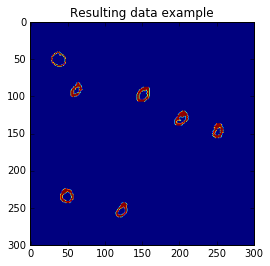

In [97]:
plt.imshow(C)
plt.title('Resulting data example')
plt.show()

In [ ]:
# Lets make some noise!!!!!

